In [1]:
%matplotlib inline

import numpy as np
# from bokeh.plotting import figure, show, output_file
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from xcel_to_df import xcel_to_df, combine_lists, needs_formatting, reformat_columns

In [2]:
def find_19_dataframe(file_prefix, quarter):
    prefix = 'excel_data/2019_data/'
    files = os.listdir(prefix)
    
    dict_list = []
    
    for file in files:
        if file.startswith(file_prefix): 
#         df = pd.read_excel('excel_data/2019_data/Sp19_wk2_B.xlsx')
            df = pd.read_excel(prefix + file)
            days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
            times= ['8', '10', '12', '2']
            col_names = combine_lists(days, times)
            if needs_formatting(df):
                df = reformat_columns(df, col_names, start=3, end=7)
                print('Fixed formatting')
                
                
            df_19 = df.drop(columns=['Structure', 'Lot'])
            positions = ['8am', '10am', '12pm', '2pm']

            df_19['8am'] = [0 for i in range(0, len(df_19))]
            df_19['9am'] = [0 for i in range(0, len(df_19))]
            df_19['10am'] = [0 for i in range(0, len(df_19))]
            df_19['11am'] = [0 for i in range(0, len(df_19))]
            df_19['12pm'] = [0 for i in range(0, len(df_19))]
            df_19['1pm'] = [0 for i in range(0, len(df_19))]
            df_19['2pm'] = [0 for i in range(0, len(df_19))]
            df_19['3pm'] = [0 for i in range(0, len(df_19))]
            df_19['4pm'] = [0 for i in range(0, len(df_19))]
            df_19['5pm'] = [0 for i in range(0, len(df_19))]

            for time, pos in zip(times, positions):
                for day in days:
                    df_19[pos] += df_19[day + '-' + time] / 5.0
                    df_19 = df_19.drop(columns=[day + '-' + time])

            df_19['9am'] = (df_19['8am'] + df_19['10am']) / 2.0
            df_19['11am'] = (df_19['10am'] + df_19['12pm']) / 2.0
            df_19['1pm'] = (df_19['12pm'] + df_19['2pm']) / 2.0
            df_19['3pm'] = (df_19['10am']) * 0.9
            df_19['4pm'] = (df_19['9am']) * 0.9
            df_19['5pm'] = (df_19['8am']) * 0.9

            # df_temp['Structure'] = df['Structure']
            # df_temp['Lot'] = df['Lot']
            # df_temp['date'] = ['2019 Spring' for x in range(0,len(df_temp))]

            df_19 = df_19.sum()
            # df_temp.head()

            df_19['date'] = '2019 ' + quarter
            df_19['year'] = '2019'
            df_new_dict = df_19.to_dict()
            df_new_dict.pop('Total Spaces')
            dict_list.append(df_new_dict)
            # df_19 = df_19.join(df_19[s].stack().reset_index(level=1, drop=True).rename('empty_spaces'))
            # df_new = pd.concat([df_temp,df_19])
            
    return dict_list

In [3]:
file_list = ['Sp19_wk2','Win19_wk2']
quarter_list = ['Spring', 'Winter']
dict_list = [find_19_dataframe(x,y) for x,y in zip(file_list,quarter_list)]
data_list = []
for i in dict_list:
    for j in i[0]:
        if isinstance(i[0][j], str):
            continue
#         print('Right')
        for idx in range(1, len(i)):
            i[0][j] += i[idx][j]
    data_list.append(i[0])
# data_list

Fixed formatting


In [4]:
prefix = 'csv_data/University-Wide/'
s = ['8am','9am','10am','11am','12pm','1pm','2pm','3pm','4pm','5pm']
def get_df(filename):
    df_University_Wide = pd.read_csv(prefix + filename)
    df_useful = df_University_Wide
    df_useful['date'] = df_useful['year'] + " " + df_useful['quarter']
    remain = ['8am','9am','10am','11am','12pm','1pm','2pm','3pm','4pm','5pm','date','year',]
    df_useful = df_University_Wide[remain]

    for data in data_list:
        df_useful.loc[len(df_useful) + 1] = data
    s = ['8am','9am','10am','11am','12pm','1pm','2pm','3pm','4pm','5pm']
    df_temp = df_useful.drop(columns = s, axis = 1)
    df_temp = df_temp.loc[(df_temp.year == '2000/01') | (df_temp.year == '2004/05') | (df_temp.year == '2010/11') | (df_temp.year == '2014/15') | (df_temp.year == '2019')]

    df_temp = df_temp.join(df_useful[s].stack().reset_index(level = 1, drop = True).rename('empty_spaces'))
    df_temp = df_temp.reset_index(drop = True)

    time_list = [s[i % 10] for i in range(0,len(df_temp))]
    df_temp['time'] = time_list

    return df_temp

# def get_total_data():
#     files = os.listdir(prefix)
#     df = []
#     for file in files:
#         df.append(get_df(file))
#     df_whole = pd.concat(df)
# #     df_whole = df_whole.groupby('groupID').sum()
#     return df_whole

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


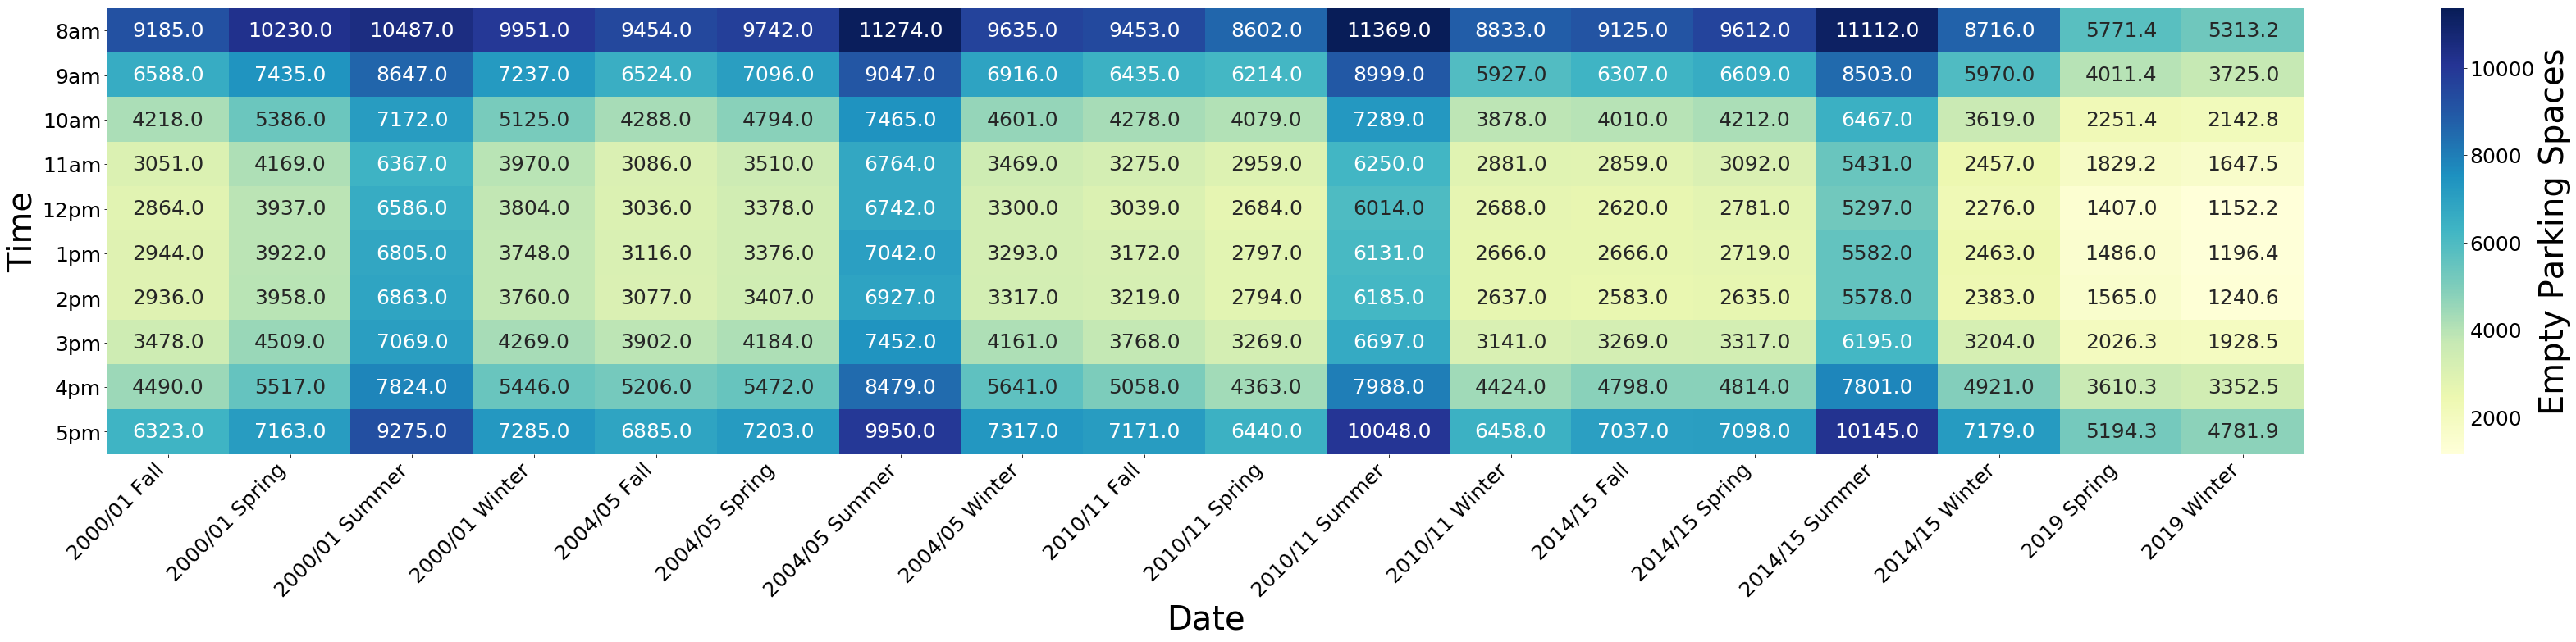

In [6]:
df_temp = get_df('University_of_California,_San_Diego__All_Parking_Spaces_Combined.csv')
spaces_data = df_temp.pivot('time','date','empty_spaces').reindex(s)
f, ax = plt.subplots(figsize=(60, 10))
ax =sns.heatmap(spaces_data,annot=True,fmt = '.1f', cmap='YlGnBu',ax=ax,cbar_kws={'label': 'Empty Parking Spaces'})
ax.figure.axes[-1].yaxis.label.set_size(40)
label_y = ax.get_yticklabels()
plt.setp(label_y, rotation=360, horizontalalignment='right',fontsize = 25)
label_x = ax.get_xticklabels()
plt.setp(label_x, rotation=45, horizontalalignment='right',fontsize = 25)
plt.rcParams['font.size'] = 25
plt.xlabel('Date', fontsize = 40)
plt.ylabel('Time', fontsize = 40)
# plt.savefig('emptyspaces_heatmap_LaJollaCampusS.png')
plt.show()

In [56]:
df_La_Jolla_S = pd.read_csv('csv_data/University-Wide/University_of_California,_San_Diego__All_Parking_Spaces_Combined.csv')
df_temp = df_La_Jolla_S
df_temp['date'] = df_temp['year'] + " " + df_temp['quarter']
remain = ['date','year','8am','9am','10am','11am','12pm','1pm','2pm','3pm','4pm','5pm']
df_temp = df_La_Jolla_S[remain]

In [57]:
df_temp.head()

,date,year,8am,9am,10am,11am,12pm,1pm,2pm,3pm,4pm,5pm
0,2000/01 Summer,2000/01,10487.0,8647.0,7172.0,6367.0,6586.0,6805.0,6863.0,7069.0,7824.0,9275.0
1,2000/01 Fall,2000/01,9185.0,6588.0,4218.0,3051.0,2864.0,2944.0,2936.0,3478.0,4490.0,6323.0
2,2000/01 Winter,2000/01,9951.0,7237.0,5125.0,3970.0,3804.0,3748.0,3760.0,4269.0,5446.0,7285.0
3,2000/01 Spring,2000/01,10230.0,7435.0,5386.0,4169.0,3937.0,3922.0,3958.0,4509.0,5517.0,7163.0
4,2001/02 Summer,2001/02,12028.0,10084.0,8483.0,7564.0,7680.0,7916.0,7884.0,8188.0,8937.0,10306.0


In [94]:
df_University_Wide = pd.read_csv('csv_data/University-Wide/University_of_California,_San_Diego__All_Parking_Spaces_Combined.csv')
df_useful = df_University_Wide
df_useful['date'] = df_useful['year'] + " " + df_useful['quarter']
remain = ['8am','9am','10am','11am','12pm','1pm','2pm','3pm','4pm','5pm','date','year',]
df_useful = df_University_Wide[remain]

for data in data_list:
    df_useful.loc[len(df_useful) + 1] = data
s = ['8am','9am','10am','11am','12pm','1pm','2pm','3pm','4pm','5pm']
df_temp = df_useful.drop(columns = s, axis = 1)
df_temp = df_temp.loc[(df_temp.year == '2000/01') | (df_temp.year == '2004/05') | (df_temp.year == '2010/11') | (df_temp.year == '2014/15') | (df_temp.year == '2019')]

df_temp = df_temp.join(df_useful[s].stack().reset_index(level = 1, drop = True).rename('empty_spaces'))
df_temp = df_temp.reset_index(drop = True)

time_list = [s[i % 10] for i in range(0,len(df_temp))]
df_temp['time'] = time_list

# df_temp['date'] = df_temp['year'] + " " + df_temp['quarter']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [50]:
df_new_dict = df_19.to_dict()
df_new_dict.pop('Total Spaces')

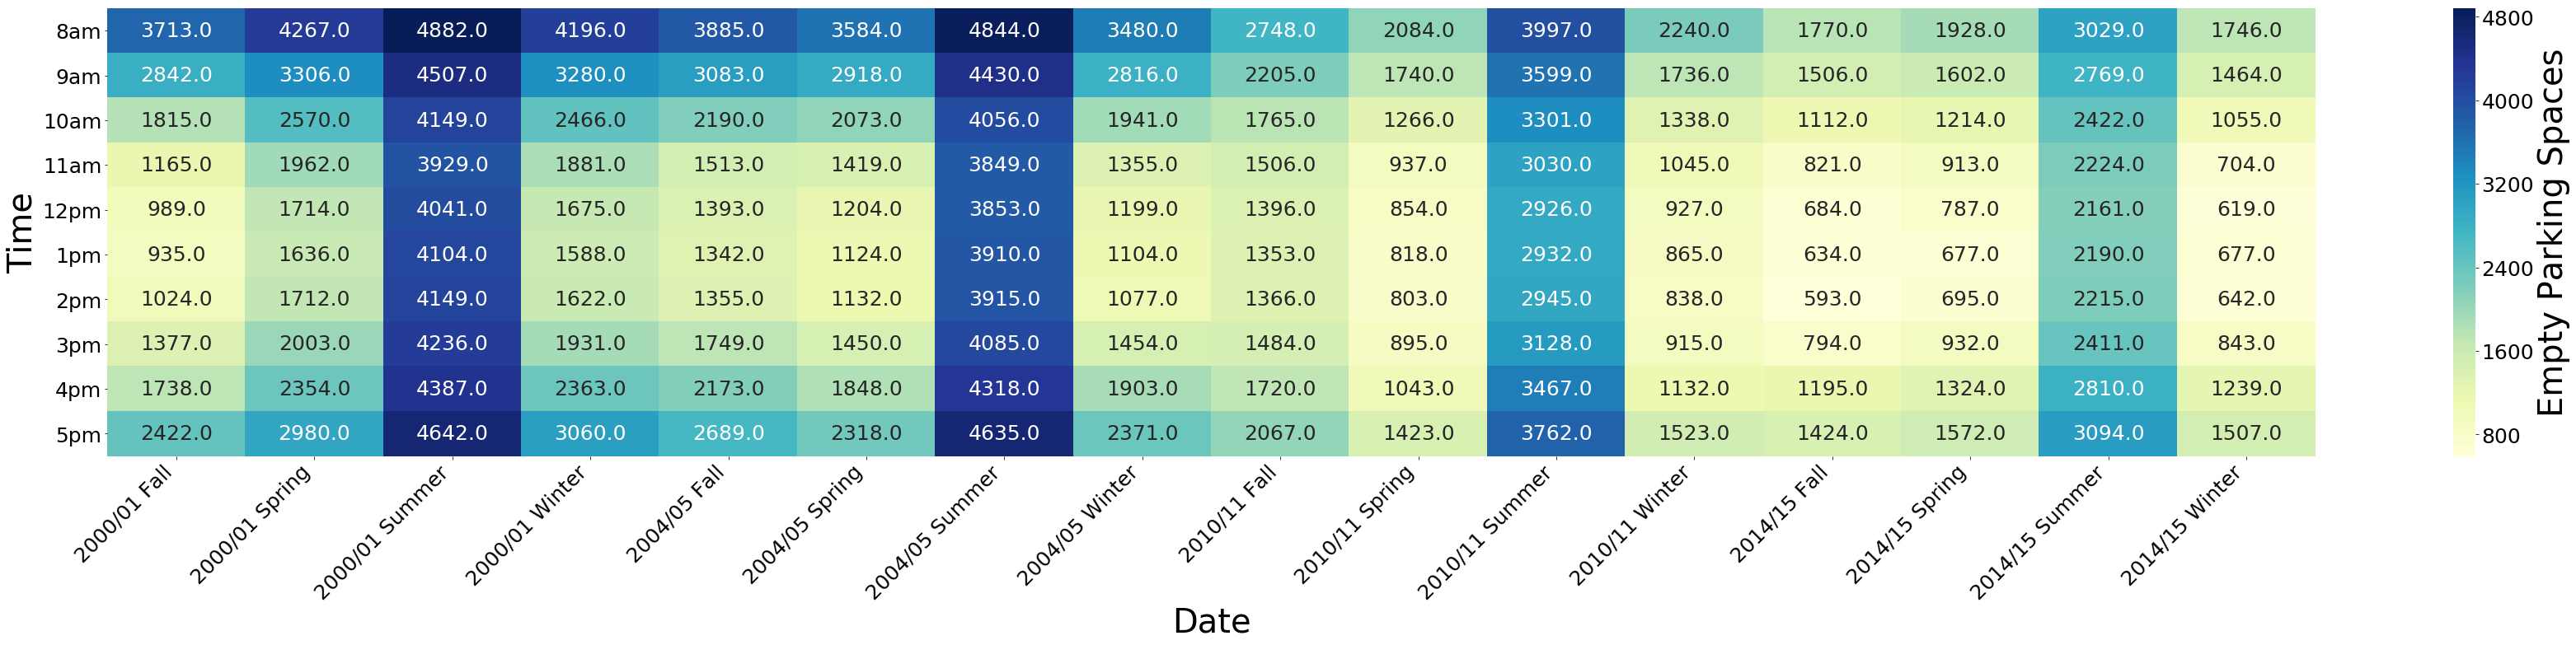

In [36]:
spaces_data = df_temp.pivot('time','date','empty_spaces').reindex(s)
f, ax = plt.subplots(figsize=(60, 10))
ax =sns.heatmap(spaces_data,annot=True,fmt = '.1f', cmap='YlGnBu',ax=ax,cbar_kws={'label': 'Empty Parking Spaces'})
ax.figure.axes[-1].yaxis.label.set_size(40)
label_y = ax.get_yticklabels()
plt.setp(label_y, rotation=360, horizontalalignment='right',fontsize = 25)
label_x = ax.get_xticklabels()
plt.setp(label_x, rotation=45, horizontalalignment='right',fontsize = 25)
plt.rcParams['font.size'] = 25
plt.xlabel('Date', fontsize = 40)
plt.ylabel('Time', fontsize = 40)
# plt.savefig('emptyspaces_heatmap_LaJollaCampusS.png')
plt.show()

In [16]:
df_La_Jolla_S = pd.read_csv('csv_data/University-Wide/University_of_California,_San_Diego__All_Parking_Spaces_Combined.csv')
df_temp = df_La_Jolla_S
df_temp['date'] = df_temp['year'] + " " + df_temp['quarter']
remain = ['date','8am','9am','10am','11am','12pm','1pm','2pm','3pm','4pm','5pm']
df_temp = df_La_Jolla_S[remain]

In [41]:
df_19 = df.drop(columns=['Structure', 'Lot'])
positions = ['8am', '10am', '12pm', '2pm']

df_19['8am'] = [0 for i in range(0, len(df_19))]
df_19['9am'] = [0 for i in range(0, len(df_19))]
df_19['10am'] = [0 for i in range(0, len(df_19))]
df_19['11am'] = [0 for i in range(0, len(df_19))]
df_19['12pm'] = [0 for i in range(0, len(df_19))]
df_19['1pm'] = [0 for i in range(0, len(df_19))]
df_19['2pm'] = [0 for i in range(0, len(df_19))]
df_19['3pm'] = [0 for i in range(0, len(df_19))]
df_19['4pm'] = [0 for i in range(0, len(df_19))]
df_19['5pm'] = [0 for i in range(0, len(df_19))]

for time, pos in zip(times, positions):
    for day in days:
        df_19[pos] += df_19[day + '-' + time] / 5.0
        df_19 = df_19.drop(columns=[day + '-' + time])

df_19['9am'] = (df_19['8am'] + df_19['10am']) / 2.0
df_19['11am'] = (df_19['10am'] + df_19['12pm']) / 2.0
df_19['1pm'] = (df_19['12pm'] + df_19['2pm']) / 2.0
df_19['3pm'] = (df_19['10am']) * 0.9
df_19['4pm'] = (df_19['9am']) * 0.9
df_19['5pm'] = (df_19['8am']) * 0.9

# df_temp['Structure'] = df['Structure']
# df_temp['Lot'] = df['Lot']
# df_temp['date'] = ['2019 Spring' for x in range(0,len(df_temp))]

df_19 = df_19.sum()
# df_temp.head()

df_19['date'] = '2019 Spring'
df_19['year'] = '2019'

# df_19 = df_19.join(df_19[s].stack().reset_index(level=1, drop=True).rename('empty_spaces'))
# df_new = pd.concat([df_temp,df_19])